# Telco Customer Churn Prediction and Visualization Project
Author: Congci(Damon) Hao

Date: 5/12/2022

## Problem Statement:

Predicting customer churn is critical for telecommunication companies to be able to effectively retain customers. It is more costly to acquire new customers than to retain existing ones. For this reason, large telecommunications corporations are seeking to develop models to predict which customers are more likely to leave and take actions accordingly. 

Therefore, I  want to build a predictive classification model to predict how likely a customer will churn by analyzing its characteristics: __(1) demographic information__, __(2) account information__, and __(3) services information__. Moreover, I would like to visualize the EDA and predictions from different ML models on an interactive Dash App.


## Relevance to GoPro
As GoPro's subscription business has been going well in 2021 (143% from a year ago in the third quarter), it is relevant and useful to leverage the knowledge from this Telco Custer Churn project to help GoPro analyze its customer base and determine the customers who are likely to churn. So the marketing/sales department can provide incentives in time to motivate those customers to stay and even bring their friends/families to GoPro subscription through referral programs.

## Data Source
Data Source: the IBM Teclo Customer Dataset from Kaggle

## Steps of the Project 

The project consists of the following sections:
1. Data Extraction and Reading
2. Data Cleaning
3. EDA
4. Feature Importance
5. Feature Engineering
6. Setting a baseline
7. Splitting the data in training and testing sets
8. Assessing multiple algorithms
9. Algorithm selected: Gradient Boosting
10. Hyperparameter tuning
11. Performance of the model
12. Drawing conclusions — Summary

In [43]:
# import standard libraries fro data analysis
import math
import kaggle
import numpy as np 
import pandas as pd 

# use Kaggle API to import the data
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# import data visualization packages
import seaborn as sns 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
from matplotlib import pyplot

# import sklearn modules for data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# import sklearn modeuls for model development
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss,CondensedNearestNeighbour
from sklearn.metrics import auc,roc_curve, f1_score, accuracy_score, classification_report, confusion_matrix, precision_recall_curve,roc_auc_score

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

# ignore matplotlib warnings to make notebook clean
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Data Extraction and Reading

In [44]:
# option 1
# use kaggle CLI commands
# !kaggle datasets download -d blastchar/telco-customer-churn

In [45]:
# option 2
# use Kaggle API methods to download the Telco Customer Churn dataset
api = KaggleApi()
api.authenticate()

api.dataset_download_file('blastchar/telco-customer-churn',
                          'WA_Fn-UseC_-Telco-Customer-Churn.csv')

False

In [46]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
# check unique values of each column
for column in df.columns:
    print('Column: {} - Unique Values: {}'.format(column, df[column].unique()))

Column: customerID - Unique Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: ['No phone service' 'No' 'Yes']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' 'No internet service']
Column: TechSuppor

As shown above, the data set contains 19 independent variables, which can be classified into 3 groups:

(1) Demographic Information
- gender: Whether the client is a female or a male (Female, Male).
- SeniorCitizen: Whether the client is a senior citizen or not ( 0, 1).
- Partner: Whether the client has a partner or not (Yes, No).
- Dependents: Whether the client has dependents or not (Yes, No).

(2) Customer Account Information
- tenure: Number of months the customer has stayed with the company (Multiple different numeric values).
- Contract: Indicates the customer’s current contract type (Month-to-Month, One year, Two year).
- PaperlessBilling: Whether the client has paperless billing or not (Yes, No).
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit Card (automatic)).
- MontlyCharges: The amount charged to the customer monthly (Multiple different numeric values).
- TotalCharges: The total amount charged to the customer (Multiple different numeric values).

(3) Services Information
- PhoneService: Whether the client has a phone service or not (Yes, No).
- MultipleLines: Whether the client has multiple lines or not (No phone service, No, Yes).
- InternetServices: Whether the client is subscribed to Internet service with the company (DSL, Fiber optic, No)
- OnlineSecurity: Whether the client has online security or not (No internet service, No, Yes).
- OnlineBackup: Whether the client has online backup or not (No internet service, No, Yes).
- DeviceProtection: Whether the client has device protection or not (No internet service, No, Yes).
- TechSupport: Whether the client has tech support or not (No internet service, No, Yes).
- StreamingTV: Whether the client has streaming TV or not (No internet service, No, Yes).
- StreamingMovies: Whether the client has streaming movies or not (No internet service, No, Yes).

Source: https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113


## 2. Data Cleaning

In [48]:
# summary of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


As shown by .info() method above, the data set contains 7043 observations and 21 columns. Luckily, there are no null values. However, the column TotalCharges was detected as an object. This column represents the total amount charged to the customer and it should be a numeric variable. 

In [49]:
# transform the column TotalCharges into a numeric data type
# Due to non-numeric values like NaN in this column, it would raise exception errors. I need to use errors = "coerce" to enforce the changes
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [50]:
# null observations of the TotalCharges column
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [51]:
# drop observations with null values
df.dropna(inplace=True)

In [52]:
# drop the customerID column from the dataset
# The customerID column is useless to explain whether not the customer will churn.
df.drop(columns='customerID', inplace=True)

In [53]:
# As shown below, some payment method denominations contain in parenthesis the word automatic. 
# These denominations are too long to be used as tick labels in further visualizations so we remove them here.
df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [54]:
# remove (automatic) from payment method names
df['PaymentMethod'] = df['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

In [55]:
# check unique values of the PaymentMethod column after the modification 
df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

## 3. EDA

The following bar plot shows the percentage of observations that correspond to each class of the response variable: no and yes. As shown below, it is an imbalanced dataset which may lead to more false negatives later in the modeling step

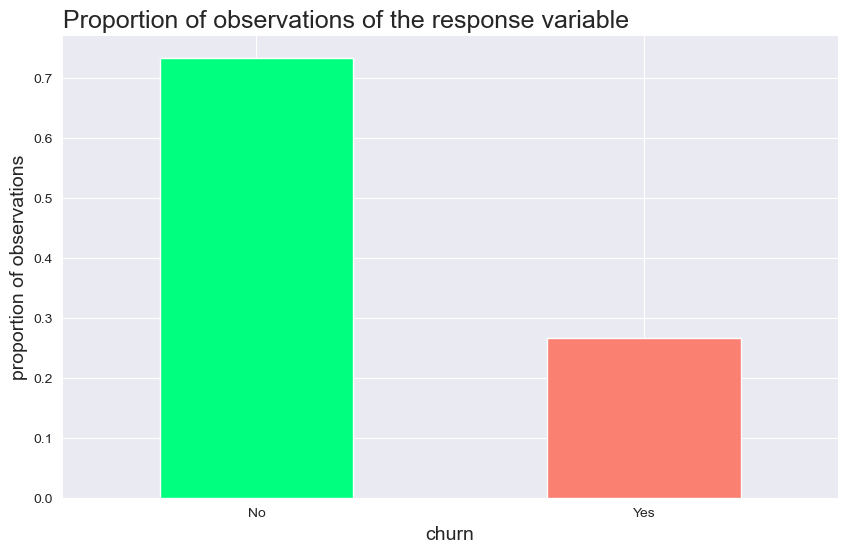

In [56]:
# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of observation of each class
prop_response = df['Churn'].value_counts(normalize=True)

# create a bar plot showing the percentage of churn
prop_response.plot(kind='bar', 
                   ax=ax,
                   color=['springgreen','salmon'])

# set title and labels
ax.set_title('Proportion of observations of the response variable',
             fontsize=18, loc='left')
ax.set_xlabel('churn',
              fontsize=14)
ax.set_ylabel('proportion of observations',
              fontsize=14)
ax.tick_params(rotation='auto')

# eliminate the frame from the plot
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)
    
plt.show()

Next we are going to use normalized stacked bar plots to analyze the influence of each independent categorical variable in the outcome. Stacked bar is very useful to compare how the target variable distributed across indenpendent variables.

### Demographic Information
The following code creates a stacked percentage bar chart for each demographic attribute (gender, SeniorCitizen, Partner, Dependents), showing the percentage of Churn for each category of the attribute.

In [57]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

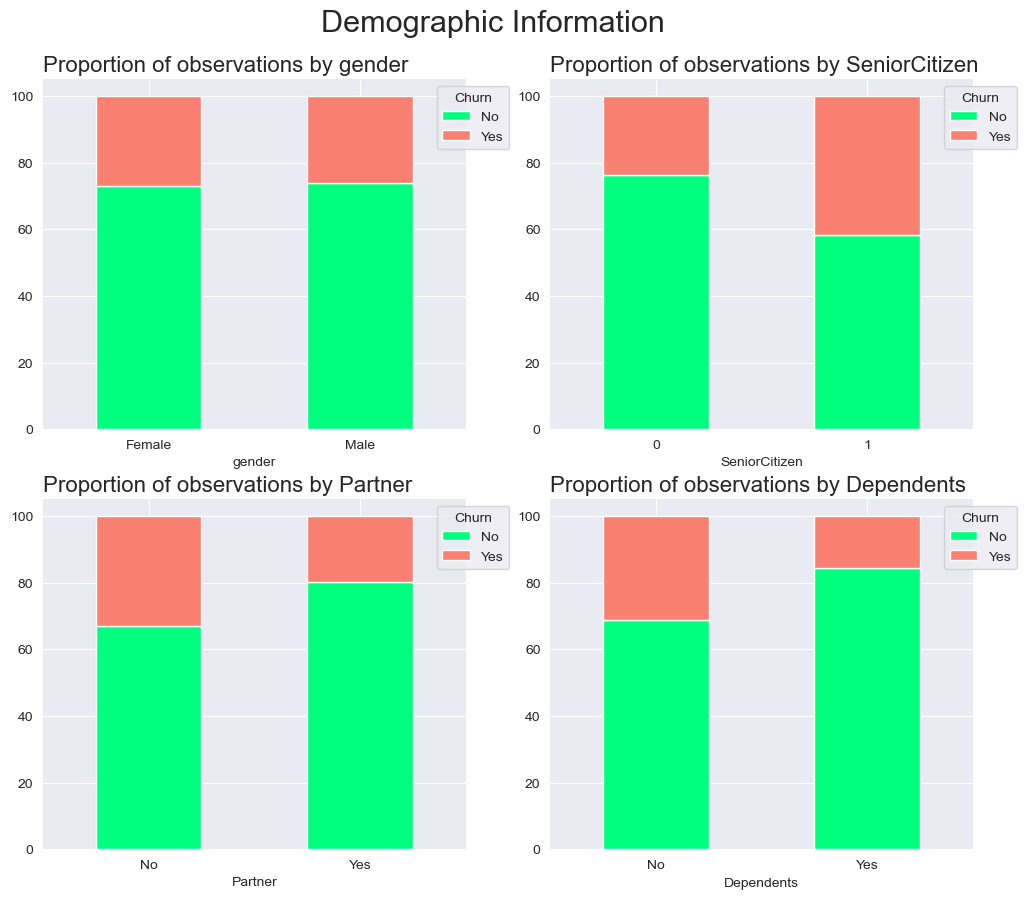

In [58]:
# demographic column names
demographic_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information')

plt.show()

As shown above, each bar is a category of the independent variable, and it is subdivided to show the proportion of each response class (No and Yes).

We can extract the following conclusions by analyzing demographic attributes:
- The churn rate of senior citizens is almost double that of young citizens.
- We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a customer is a man or a woman.
- Customers with a partner churn less than customers with no partner.

### Customer Account Information — Categorical variables
As we did with demographic attributes, we evaluate the percentage of Churn for each category of the customer account attributes (Contract, PaperlessBilling, PaymentMethod).

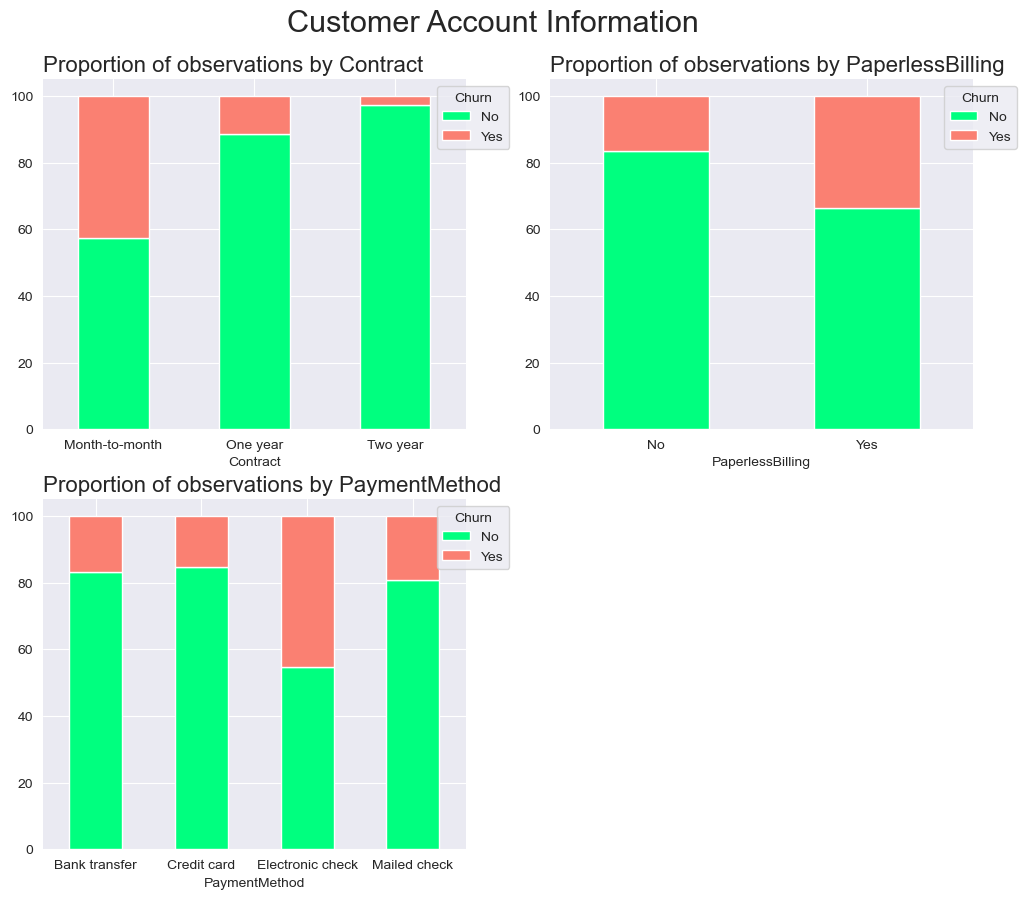

In [59]:
# customer account column names
account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Customer Account Information')

plt.show()

We can extract the following conclusions by analyzing customer account attributes:
- Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.
- Customers who opted for an electronic check as paying method are more likely to leave the company.
- Customers subscribed to paperless billing churn more than those who are not subscribed.

### Customer Account Information — Numerical variables



For custoemr account information, we use histograms to evaluate the influence of each independent numeric variable in the outcome. Since the data set is imbalanced, we used a probability density function of each class to compare distributions properly.

The following plots show the distribution of tenure, MontlyCharges, TotalCharges by Churn. For all numeric attributes, the distributions of both classes (No and Yes) are different which suggests that all of the attributes will be useful to determine whether or not a customer churns.

In [60]:
def histogram_plots(columns_to_plot, super_title):

    '''
     Prints a histogram for each independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)


    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # histograms for each class (normalized histogram)
        df[df['Churn']=='No'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, color='springgreen', label='No')
        df[df['Churn']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, color='salmon', label='Yes')

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

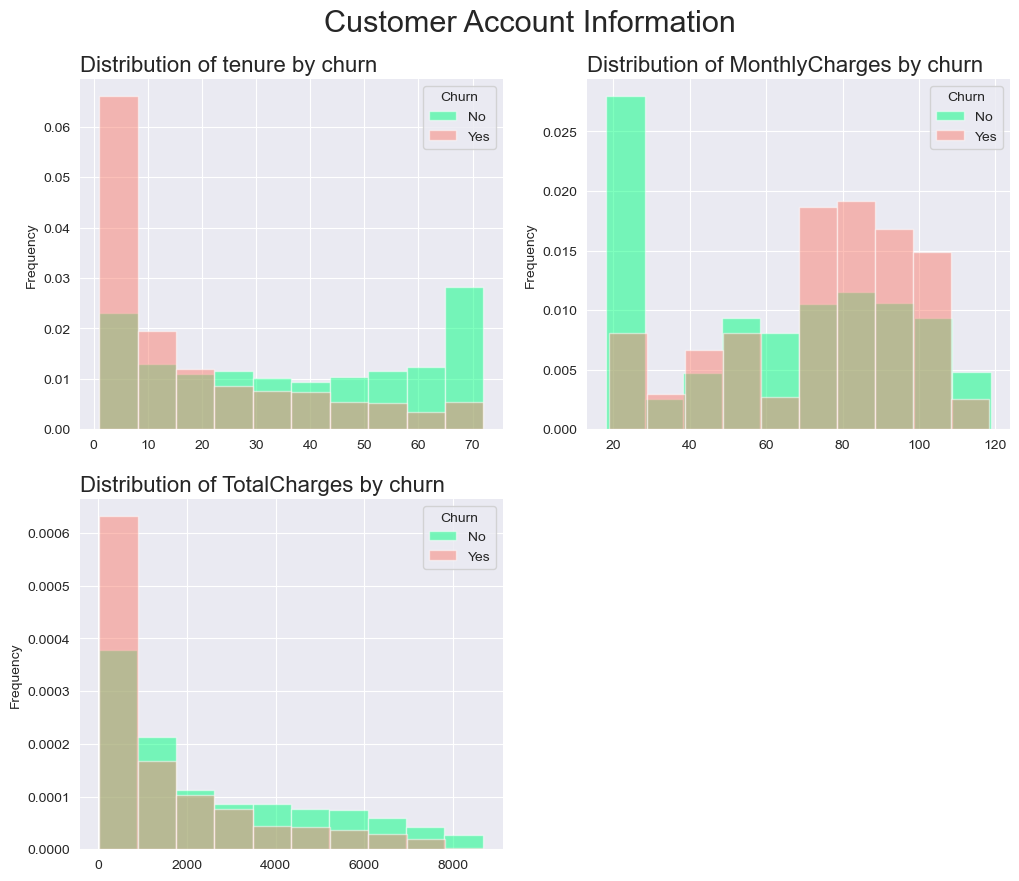

In [61]:
# customer account column names
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
# histogram of costumer account columns 
histogram_plots(account_columns_numeric, 'Customer Account Information')

plt.show()

We can extract the following conclusions by analyzing the histograms above:
- The churn rate tends to be larger when monthly charges are high.
- New customers (low tenure) are more likely to churn.
- Clients with high total charges are less likely to leave the company.

### Services Information
Lastly, we evaluate the percentage of the target for each category of the services columns with stacked bar plots.

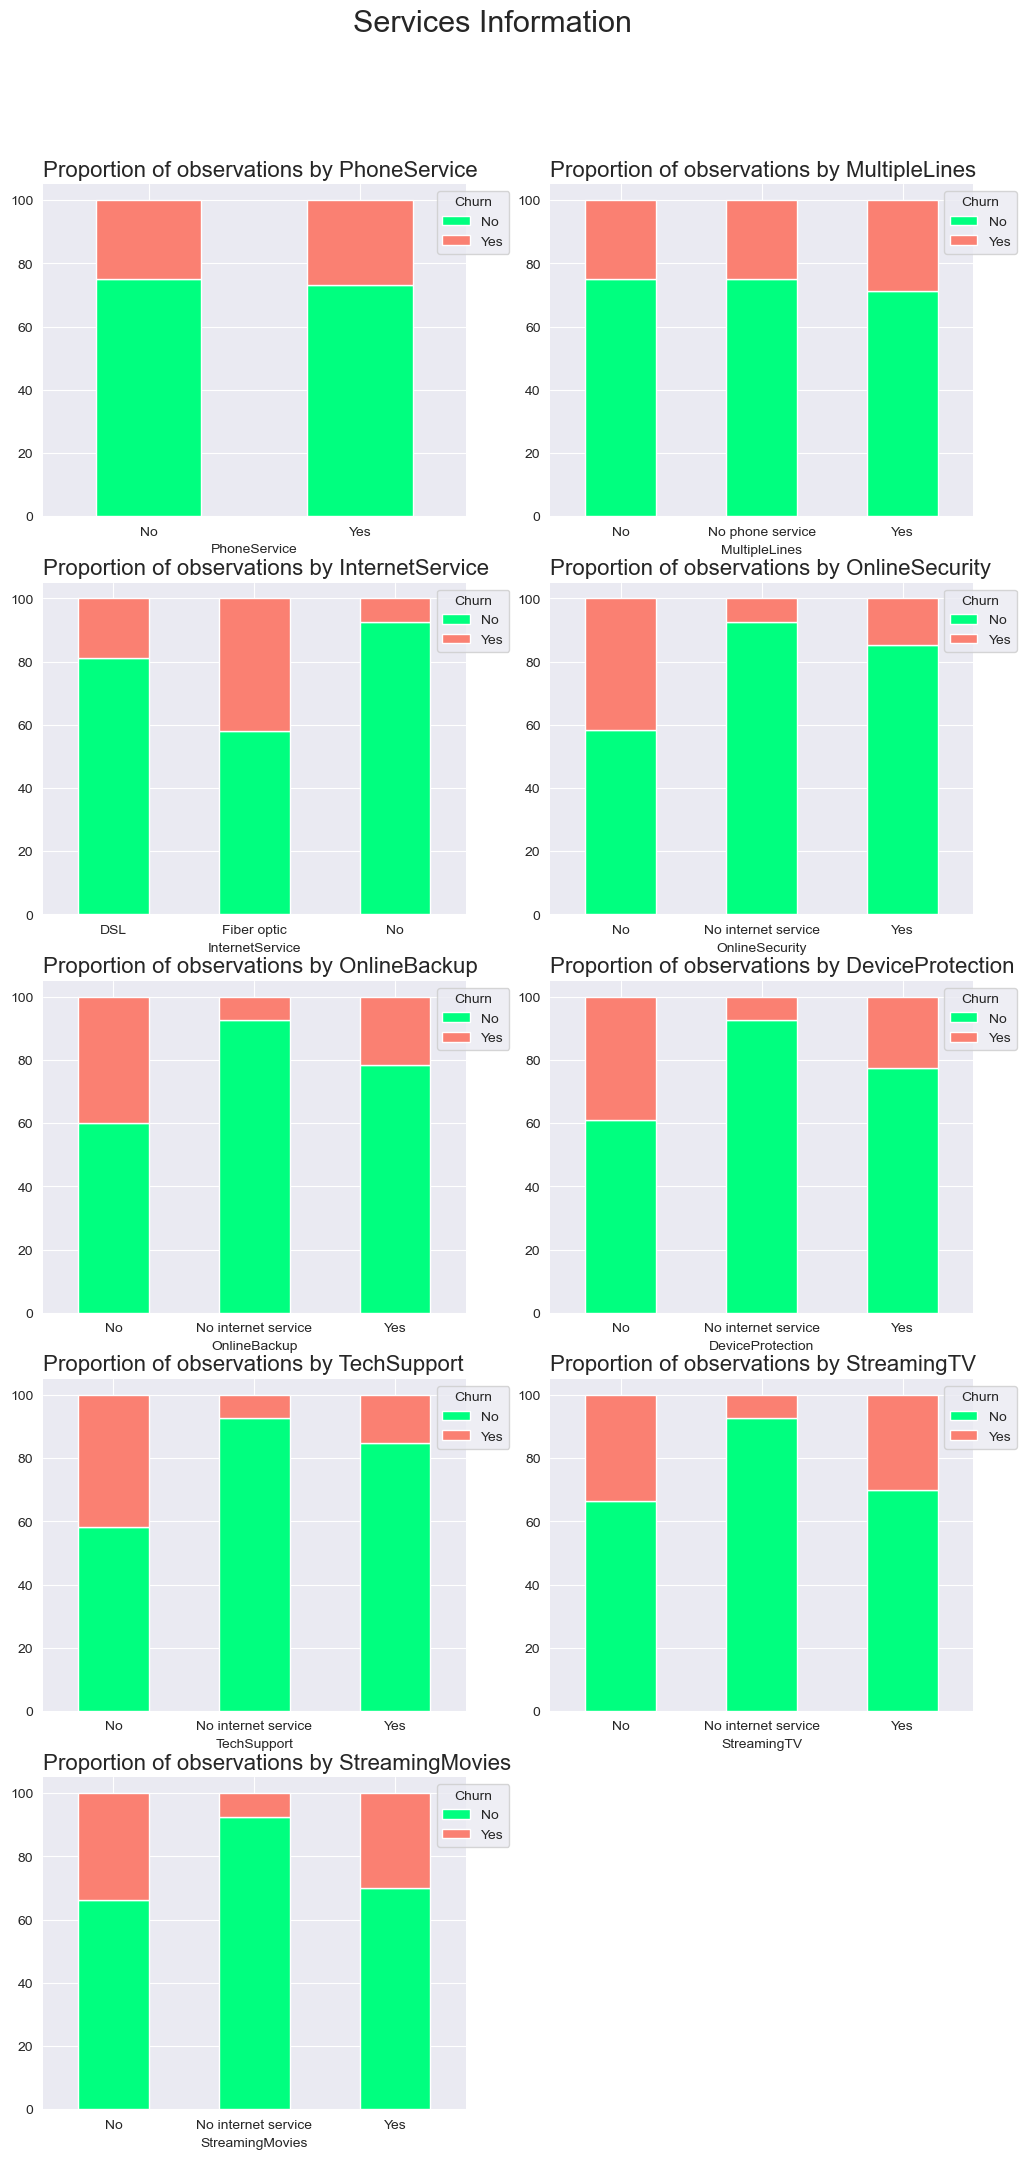

In [62]:
# services column names
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Services Information')

plt.show()

We can extract the following conclusions by evaluating services attributes:
- We do not expect phone attributes (PhoneService and MultipleLines) to have significant predictive power. The percentage of churn for all classes in both independent variables is nearly the same.
- Clients with online security churn less than those without it.
- Customers with no tech support tend to churn more often than those with tech support.

By looking at the plots above, we can identify the most relevant attributes for detecting churn. We expect these attributes to be discriminative in our future models.

### 4. Check Feature Importance
Now, we are interested in evaluating the degree of dependency between each independent variable and the target variable. The higher the values of mutual information are, the higher degree of dependency the predictor has, which indicates that the independent variable will be useful for predicting the target.


In [63]:
from sklearn.metrics import mutual_info_score
# function that computes the mutual infomation score between a categorical serie and the column Churn
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.Churn)

# select categorial variables excluding the response variable 
categorical_variables = df.select_dtypes(include=object).drop('Churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

Contract            0.098182
OnlineSecurity      0.064528
TechSupport         0.062873
InternetService     0.055394
OnlineBackup        0.046659
PaymentMethod       0.044423
DeviceProtection    0.043784
StreamingMovies     0.031918
StreamingTV         0.031803
PaperlessBilling    0.019119
Dependents          0.014270
Partner             0.011383
MultipleLines       0.000798
PhoneService        0.000069
gender              0.000037
dtype: float64


Based on the results above,we can see that gender, PhoneService, and MultipleLines have a mutual information score close to 0, meaning those variables do not have a strong relationship with the target. This information is aligned with the conclusions from EDA. Therefore, we should consider removing these variables. 

## 5. Feature Engineering

1. Encode all categorical attributes into numerical labels before training the model

2. Normalize numeric columns into a common scale

### Label Encoding
Transform the following categorical variables:(1) gender, (2) Partner, (3) Dependents, (4)PaperlessBilling, (5)PhoneService , and (6)Churn .

In [64]:
df_telco_transformed = df.copy()

# label encoding (binary variables)
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService', 'Churn']

# encode categorical binary features using label encoding
for column in label_encoding_columns:
    if column == 'gender':
        df_telco_transformed[column] = df_telco_transformed[column].map({'Female': 1, 'Male': 0})
    else: 
        df_telco_transformed[column] = df_telco_transformed[column].map({'Yes': 1, 'No': 0}) 


### One-Hot Encoding
Apply one-hot encoding to the following categorical variables: (1) Contract, (2) PaymentMethod, (3) MultipleLines, (4) InternetServices, (5) OnlineSecurity, (6) OnlineBackup, (7) DeviceProtection, (8) TechSupport, (9) StreamingTV, and (10)StreamingMovies.

In [65]:
# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                            'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']

# encode categorical variables with more than two levels using one-hot encoding
df_telco_transformed = pd.get_dummies(df_telco_transformed, columns = one_hot_encoding_columns)


### Normalization

In [66]:
# min-max normalization (numeric variables)
min_max_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# scale numerical variables using min max scaler
for column in min_max_columns:
        # minimum value of the column
        min_column = df_telco_transformed[column].min()
        # maximum value of the column
        max_column = df_telco_transformed[column].max()
        # min max scaler
        df_telco_transformed[column] = (df_telco_transformed[column] - min_column) / (max_column - min_column)   


### Binning 'tenure' feature into 6 ranges

In [74]:
condition = [((df.tenure >= 0)&(df.tenure <= 12)), ((df.tenure > 12)&(df.tenure <= 24)), 
             ((df.tenure > 24)&(df.tenure <= 36)),((df.tenure > 36)&(df.tenure <= 48)),
             ((df.tenure > 48)&(df.tenure <= 60)), (df.tenure > 60)]

#choice = ['0-1year','1-2years', '2-3years', '3-4years','4-5years','more than 5 years']
choice = [0,1, 2, 3, 4, 5]
df['tenure_range'] = np.select(condition, choice)

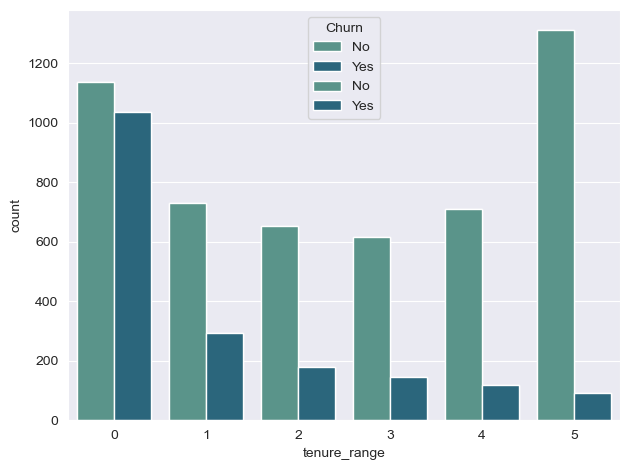

In [77]:
_ = sns.countplot(x= 'tenure_range', hue='Churn', data=df, palette='crest', order=choice)
plt.tight_layout()
plt.show()

- We can notice that customers who stay longer are more loyal to the company and very small number who leave after staying more than 4 years. On the other hand, customers churn rate is very high during the first year.

## 6. Splitting the data in training and testing sets

In [67]:
# select independent variables
X = df_telco_transformed.drop(columns='Churn')

# select dependent variables
y = df_telco_transformed.loc[:, 'Churn']

# prove that the variables were selected correctly
print(X.columns)

# prove that the variables were selected correctly
print(y.name)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'], dtype='object')
Churn


In [68]:
# split the data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=40, shuffle=True)

## 7. Assessing multiple algorithms
We are building the following six models:
- Dummy classifier (baseline)
- K Nearest Neighbours
- Logistic Regression
- Support Vector Machines
- Random Forest
- Gradiente Boosting

In [69]:
# define a function to create a list of machine learning models 
def create_models(seed=2):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    
    return models

# create a list with all the algorithms we are going to assess
models = create_models()

In [70]:

# test the accuracy of each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model with the training data
    model.fit(X_train, y_train).predict(X_test)
    # make predictions with the testing data
    predictions = model.predict(X_test)
    # calculate accuracy 
    accuracy = accuracy_score(y_test, predictions)
    # append the model name and the accuracy to the lists
    results.append(accuracy)
    names.append(name)
    # print classifier accuracy
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

Classifier: dummy_classifier, Accuracy: 0.745164960182025)
Classifier: k_nearest_neighbors, Accuracy: 0.7531285551763367)
Classifier: logistic_regression, Accuracy: 0.7923777019340159)
Classifier: support_vector_machines, Accuracy: 0.7878270762229806)
Classifier: random_forest, Accuracy: 0.7713310580204779)
Classifier: gradient_boosting, Accuracy: 0.7963594994311718)


## 8. Hyperparameter tuning
We select Gradient Boosting as the best algorithm to make predictions because it has the highest accuracy. However, we would like to tune all pararmeters for Gradient Boosting. We use k-fold cross-validation for hyperparameter tuning. The training set is divided again into k equal-sized samples, 1 sample is used for testing and the remaining k-1 samples are used for training the model, repeating the process k times. Then, the k evaluation metric are averaged to produce a single estimator.

In [79]:
# define the parameter grid
grid_parameters = {'n_estimators': [80, 90, 100, 110, 115, 120],
                   'max_depth': [3, 4, 5, 6],
                   'max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=grid_parameters,
                                   cv=5,
                                   n_iter=150,
                                   n_jobs=-1)

# fitting the model for random search 
random_search.fit(X_train, y_train)

# print best parameter after tuning
print(random_search.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 3}


After fitting the grid object, we can obtain the best hyperparameters using best_params_attribute. As you can above, the best hyperparameters are: {‘n_estimators’: 90, ‘min_samples_split’: 3, ‘max_features’: ‘log2’, ‘max_depth’: 3}.

## 9. Model Evaluation
The last step of the machine learning process is to check the performance of the model (best hyperparameters ) by using the confusion matrix and some evaluation metrics.

In [80]:
# make the predictions
random_search_predictions = random_search.predict(X_test)

# construct the confusion matrix
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# visualize the confusion matrix
confusion_matrix

cm = confusion_matrix(random_search_predictions, y_test)
f, ax= plt.subplots(1,1,figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=16)
ax.set_ylabel('True labels', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['No', 'Yes'], fontsize=16)
ax.yaxis.set_ticklabels(['No', 'Yes'], fontsize=16)

array([[1151,  159],
       [ 196,  252]], dtype=int64)

In [81]:
# print classification report 
print(classification_report(y_test, random_search_predictions))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1310
           1       0.61      0.56      0.59       448

    accuracy                           0.80      1758
   macro avg       0.73      0.72      0.73      1758
weighted avg       0.79      0.80      0.80      1758



As shown above, we obtain a sensitivity of 0.55 (248/(200+248)) and a specificity of 0.88 (1154/(1154+156)). The model obtained predicts more accurately customers that do not churn. This should not surprise us at all, since gradient boosting classifiers are usually biased toward the classes with more observations.

In [82]:
# print the accuracy of the model
accuracy_score(y_test, random_search_predictions)

0.79806598407281

GB: f1=0.587 auc=0.617


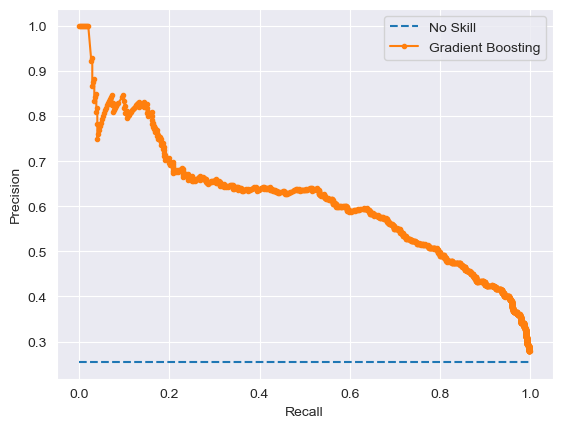

In [86]:
# predict probabilities
lr_probs = random_search.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, random_search_predictions), auc(lr_recall, lr_precision)
# summarize scores
print('GB: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Gradient Boosting')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
GB: ROC AUC=0.839


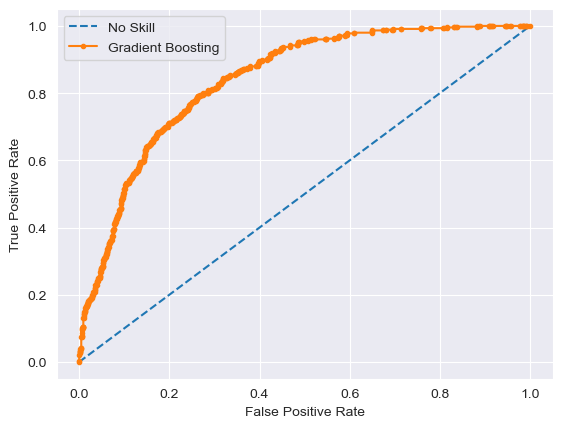

In [87]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model

# predict probabilities
lr_probs = random_search.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('GB: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Gradient Boosting')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

As the results show above, hyperparameter tuning didn't increase the accuracy of the model significantly.

## 10. Recommendation
 We would consider the Gradient Boosting Classifier as the best performance model to predict customer churns with an accuracy rate of nearly 80%.